In [1]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [2]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
import numpy as np

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [3]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu_layer = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu_layer(x)
        std = torch.exp(self.log_std)
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.value_layer(x)
        return value


## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [6]:
class PPO(nn.Module):
    def __init__(self, env, config):
        super(PPO, self).__init__()
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size
        self.lr = config.LEARNING_RATE
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory()

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).to(device)
        mu, std = self.actor(state_tensor)
        normal = torch.distributions.Normal(mu, std)
        action = normal.sample()
        # Sum log probabilities across action dimensions
        log_prob = normal.log_prob(action).sum(dim=-1)
        value = self.critic(state_tensor)
        self.push_memory(state_tensor, action, log_prob, value)
        return action.squeeze(0).cpu().numpy()

    def evaluate(self, state, action):
        mu, std = self.actor(state)
        normal = torch.distributions.Normal(mu, std)
        # Sum log probabilities over action dimensions
        action_logprobs = normal.log_prob(action).sum(dim=-1)
        # Sum entropy over action dimensions
        entropy = normal.entropy().sum(dim=-1)
        state_value = self.critic(state)
        return action_logprobs, state_value, entropy

    def update(self):
        old_states, old_actions, old_logprobs, old_state_vals = self.load_memory()
        rewards_list = self.memory.rewards
        discounted_reward = 0
        returns = []
        for r in reversed(rewards_list):
            discounted_reward = r + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        gae = 0
        advantages = []
        old_state_vals_list = [val.item() for val in old_state_vals]
        for i in reversed(range(len(rewards_list))):
            next_value = 0 if i == len(rewards_list) - 1 else old_state_vals_list[i + 1]
            delta = rewards_list[i] + self.gamma * next_value - old_state_vals_list[i]
            gae = delta + self.gamma * self.gae_lambda * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        loss_ac = 0
        loss_cri = 0
        for _ in range(self.epochs):
            action_logprobs, state_values, entropy = self.evaluate(old_states, old_actions)
            ratios = torch.exp(action_logprobs - old_logprobs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2) - 0.01 * entropy
            loss_critic = F.mse_loss(state_values.squeeze(), returns)
            loss_actor = loss_actor.mean()
            loss_critic = loss_critic.mean()
            self.optimizer_actor.zero_grad()
            loss_actor.backward(retain_graph=True)
            loss_ac += loss_actor.item()
            self.optimizer_actor.step()
            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            loss_cri += loss_critic.item()
            self.optimizer_critic.step()
        self.memory.clear()
        return loss_ac, loss_cri

    def push_memory(self, state, action, log_prob, value):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self):
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_state_vals = torch.stack(self.memory.state_values).detach()
        return old_states, old_actions, old_logprobs, old_state_vals

    def store_reward(self, reward):
        self.memory.rewards.append(reward)


## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [7]:
class Config:
    SEED = 111
    MAX_EPISODES = 8000
    K_EPOCHS = 5
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 0.000365
    BETAS = (0.9, 0.99)
    hidden_size = 128
    GAE = 0.95
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

Training PPO on HalfCheetah: 100%|██████████| 8000/8000 [2:59:50<00:00,  1.35s/it, Reward=3575.34, Actor Loss=-11.748530, Critic Loss=32573.892578]


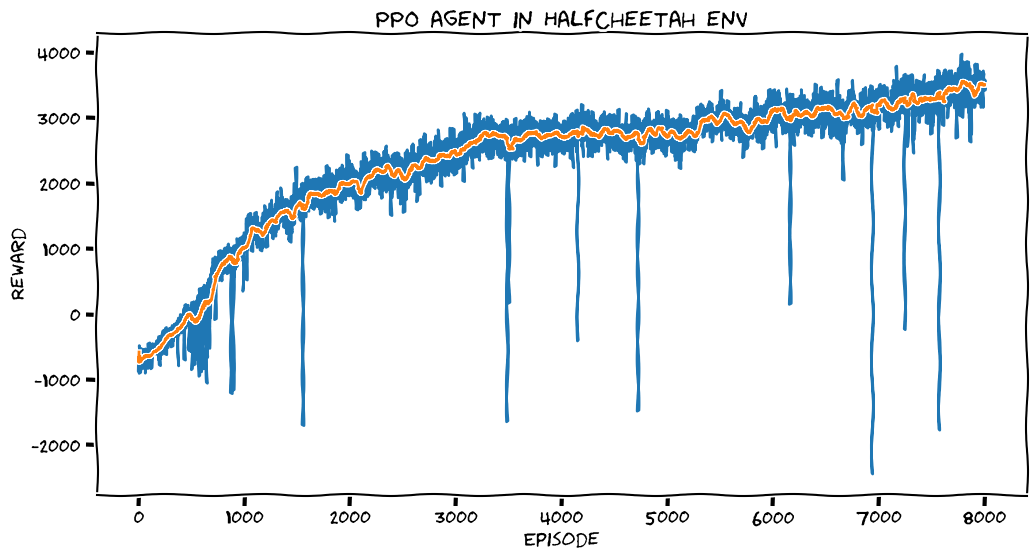

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [8]:
from tqdm import tqdm

env = gym.make("HalfCheetah-v4")
config = Config()

agent = PPO(env, config)

actor_losses = []
critic_losses = []
rewards_history = []

pbar = tqdm(range(config.MAX_EPISODES), desc="Training PPO on HalfCheetah")
for episode in pbar:
    state, _ = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        agent.store_reward(reward)
        state = next_state
        if terminated or truncated:
            done = True

    loss_ac, loss_cri = agent.update()
    actor_losses.append(loss_ac)
    critic_losses.append(loss_cri)
    rewards_history.append(episode_reward)

    pbar.set_postfix({
        "Reward": f"{episode_reward:.2f}",
        "Actor Loss": f"{loss_ac:.6f}",
        "Critic Loss": f"{loss_cri:.6f}"
    })

env.close()
plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')


# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [9]:
%env MUJOCO_GL=egl
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

while not done:
    frame = env.render()
    frames.append(frame)
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    state = next_state
    done = terminated or truncated

env.close()
print(f"Total Reward: {total_reward}")

video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)
show_video(video_path)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


env: MUJOCO_GL=egl
Total Reward: 3254.953567457911
